<a href="https://www.kaggle.com/code/koheimuramatsu/recommendation-systems-study?scriptVersionId=107566784" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h2 style="text-align:center;font-size:200%;">
    <b>Recommendation Systems Study</b>
</h2>
<h3  style="text-align:center;">Keywords : 
    <span style="border-radius:7px;background-color:limegreen;color:white;padding:7px;">Recommendation</span>
    <span style="border-radius:7px;background-color:limegreen;color:white;padding:7px;">NLP</span>
    <span style="border-radius:7px;background-color:limegreen;color:white;padding:7px;">EDA</span>
</h3>

<hr>

<h2 style="font-size:150%;"><span id='top'>Table of Contents</span></h2>
<blockquote>
    <ol>
        <li><a href="#Overview">Overview</a></li>
        <li><a href="#Preparation">Preparation</a></li>
        <li><a href="#Data-Load">Data Load</a></li>
        <li><a href="#Pre-Processing">Pre-Processing</a></li>
        <ul>
            <li><a href="#Check-Missing-Values">Check Missing Values</a></li>
            <li><a href="#Transform">Transform</a></li>
            <li><a href="#Concatination">Concatination</a></li>
        </ul>
        <li><a href="#EDA">EDA</a></li>
        <li><a href="#Recommendation">Recommendation</a></li>
        <ul>
            <li><a href="#Class-Definitions">Class Definitions</a></li>
            <li><a href="#Popularity">Popularity</a></li> 
            <li><a href="#Colloaborative-Filter">Colloaborative Filter</a></li>
            <li><a href="#Item2vec">Item2vec</a></li> 
            <li><a href="#Matrix-Factorization">Matrix Factorization</a></li> 
            <li><a href="#Factorization-Machines">Factorization Machines</a></li> 
        </ul>
        <li><a href="#References">References</a></li>
    </ol>
</blockquote>

# Overview
## About the Dataset
- Full MovieLens Dataset
- Metadata of Movies, Ratings by users
## What You Get from this Notebook
- ETL technique
- EDA & Visualization
- Recommendation Algorithms

# Preparation

In [1]:
import os

import numpy as np
import pandas as pd 
import json
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from ast import literal_eval
from typing import Dict, List
import dataclasses
from abc import ABC, abstractmethod
from collections import defaultdict
import gensim

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import warnings
warnings.filterwarnings('ignore')

from surprise import KNNWithMeans, SVD, Reader
from surprise import Dataset as SurpriseDataset

## For xlearn installation
os.environ['USER'] = 'root'
os.system('pip install xlearn -t /kaggle/working --root-user-action=ignore')
import xlearn as xl
#########################
from sklearn.feature_extraction import DictVectorizer

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for xlearn: filename=xlearn-0.40a1-py3-none-any.whl size=225766 sha256=742f73ead5fefef6842f6db229b63edd7568d6851ad10676a3e56ada061e2218
  Stored in directory: /root/.cache/pip/wheels/1e/6d/eb/256faaf8142a9363431e2dc3f6a3d1c9080f526a1e5475049d
Successfully built xlearn


<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

# Data Load

In [2]:
md = pd.read_csv('../input/the-movies-dataset/movies_metadata.csv')
links= pd.read_csv('../input/the-movies-dataset/links_small.csv')
credits = pd.read_csv('../input/the-movies-dataset/credits.csv')
keywords = pd.read_csv('../input/the-movies-dataset/keywords.csv')
ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

# Pre-Processing

## Check Missing Values

In [3]:
print('### md ###')
print( md.isnull().sum() / len(md) )
print('\n### links ###')
print( links.isnull().sum() / len(links) )
print('\n### credits ###')
print( credits.isnull().sum() / len(credits) )
print('\n### keywords ###')
print( keywords.isnull().sum() / len(keywords) )
print('\n### ratings ###')
print( ratings.isnull().sum() / len(ratings) )

### md ###
adult                    0.000000
belongs_to_collection    0.901157
budget                   0.000000
genres                   0.000000
homepage                 0.828839
id                       0.000000
imdb_id                  0.000374
original_language        0.000242
original_title           0.000000
overview                 0.020983
popularity               0.000110
poster_path              0.008490
production_companies     0.000066
production_countries     0.000066
release_date             0.001914
revenue                  0.000132
runtime                  0.005785
spoken_languages         0.000132
status                   0.001914
tagline                  0.551049
title                    0.000132
video                    0.000132
vote_average             0.000132
vote_count               0.000132
dtype: float64

### links ###
movieId    0.000000
imdbId     0.000000
tmdbId     0.001425
dtype: float64

### credits ###
cast    0.0
crew    0.0
id      0.0
dtype: float64


In [4]:
md = md[["id","title","genres","original_language","overview","release_date","vote_average", "vote_count"]]
credits = credits[["id","cast"]]

## Transform

### md

In [5]:
md["id"] = md["id"].astype(str)
md["title"] = md["title"].astype(str)
md["genres"] = md["genres"].astype(str)
md["original_language"] = md["original_language"].astype(str)
md["overview"] = md["overview"].astype(str)
md["release_date"] = md["release_date"].astype(str)
md.dtypes

id                    object
title                 object
genres                object
original_language     object
overview              object
release_date          object
vote_average         float64
vote_count           float64
dtype: object

In [6]:
def unpack_genre(x):
    eval_x = literal_eval(x)
    if len(eval_x) == 0:
        return None
    else:
        return [ i['name'] for i in eval_x]
md['genres'] = md.genres.apply(lambda x : unpack_genre(x) )

In [7]:
def transform_date(x):
    x = x.split("-")[0]
    if x == 'nan':
        return None
    else:
        return x
md["release_date"] = md.release_date.apply(lambda x : transform_date(x) )

### keyword

In [8]:
keywords["id"] = keywords["id"].astype(str)
keywords["keywords"] = keywords["keywords"].astype(str)
keywords.dtypes

id          object
keywords    object
dtype: object

In [9]:
def unpack_keywords(x):
    eval_x = literal_eval(x)
    if len(eval_x) == 0:
        return None
    else:
        return [ i['name'] for i in eval_x]
keywords['keywords'] = keywords.keywords.apply(lambda x : unpack_keywords(x) )

### ratings

In [10]:
ratings["userId"] = ratings["userId"].astype(str)
ratings["movieId"] = ratings["movieId"].astype(str)
ratings.dtypes

userId        object
movieId       object
rating       float64
timestamp      int64
dtype: object

### credits

In [11]:
credits["id"] = credits["id"].astype(str)
credits["cast"] = credits["cast"].astype(str)
credits.dtypes

id      object
cast    object
dtype: object

In [12]:
def unpack_cast(x):
    eval_x = literal_eval(x)
    if len(eval_x) == 0:
        return None
    else:
        return [ i['name'] for i in eval_x]
credits["cast"] = credits.cast.parallel_apply(lambda x : unpack_cast(x) )

## Concatination

### Movie Table

In [13]:
movies = pd.merge(md, keywords, on='id', how='inner')
movies = pd.merge(movies, credits, on='id', how='inner').rename(columns={"id":"movieId"})
movies.head(3)

,movieId,title,genres,original_language,overview,release_date,vote_average,vote_count,keywords,cast
0,862,Toy Story,"[Animation, Comedy, Family]",en,"Led by Woody, Andy's toys live happily in his ...",1995,7.7,5415.0,"[jealousy, toy, boy, friendship, friends, riva...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney..."
1,8844,Jumanji,"[Adventure, Fantasy, Family]",en,When siblings Judy and Peter discover an encha...,1995,6.9,2413.0,"[board game, disappearance, based on children'...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,..."
2,15602,Grumpier Old Men,"[Romance, Comedy]",en,A family wedding reignites the ancient feud be...,1995,6.5,92.0,"[fishing, best friend, duringcreditsstinger, o...","[Walter Matthau, Jack Lemmon, Ann-Margret, Sop..."


### Ratings Table

In [14]:
movie_ratings = pd.merge( ratings, movies,  on='movieId', how='left')
movie_ratings.head(3)

,userId,movieId,rating,timestamp,title,genres,original_language,overview,release_date,vote_average,vote_count,keywords,cast
0,1,31,2.5,1260759144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1029,3.0,1260759179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1061,3.0,1260759182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

# EDA

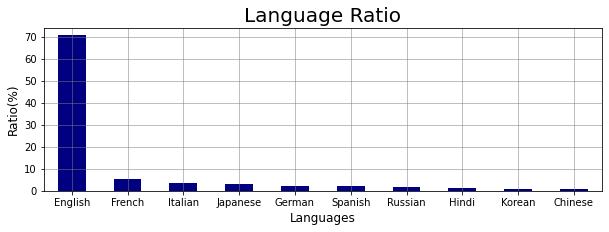

In [15]:
plt.figure()
d = movies.original_language.value_counts(normalize=True)[0:10] * 100
ax = d.plot(kind='bar', figsize=(10, 3), colormap='jet', rot=0)
ax.tick_params(axis='x', labelsize=10, rotation=0);ax.tick_params(axis='y', labelsize=10, rotation=0)
ax.set_xticklabels(["English", "French", "Italian", "Japanese", "German", "Spanish","Russian","Hindi","Korean","Chinese"])
ax.set_ylabel('Ratio(%)', fontsize=12); ax.set_xlabel('Languages', fontsize=12)
ax.set_title('Language Ratio', fontsize=20)
ax.grid(which = "major", color="gray", linewidth=0.5)
plt.show()

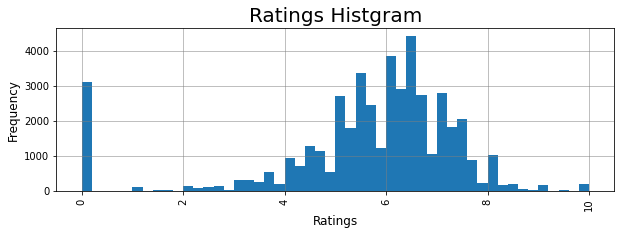

In [16]:
plt.figure()
d = movies.vote_average
ax = d.hist( figsize=(10, 3), bins=50)
ax.tick_params(axis='x', labelsize=10, rotation=90);ax.tick_params(axis='y', labelsize=10, rotation=0)
ax.set_ylabel('Frequency', fontsize=12); ax.set_xlabel('Ratings', fontsize=12)
ax.set_title('Ratings Histgram', fontsize=20)
ax.grid(which = "major", color="gray", linewidth=0.5)
plt.show()

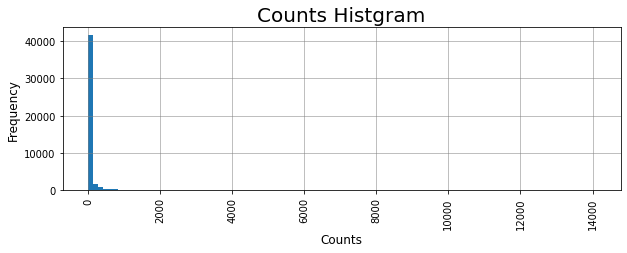

In [17]:
plt.figure()
d = movies.vote_count
ax = d.hist( figsize=(10, 3), bins=100)
ax.tick_params(axis='x', labelsize=10, rotation=90);ax.tick_params(axis='y', labelsize=10, rotation=0)
ax.set_ylabel('Frequency', fontsize=12); ax.set_xlabel('Counts', fontsize=12)
ax.set_title('Counts Histgram', fontsize=20)
ax.grid(which = "major", color="gray", linewidth=0.5)
plt.show()

<Figure size 432x288 with 0 Axes>

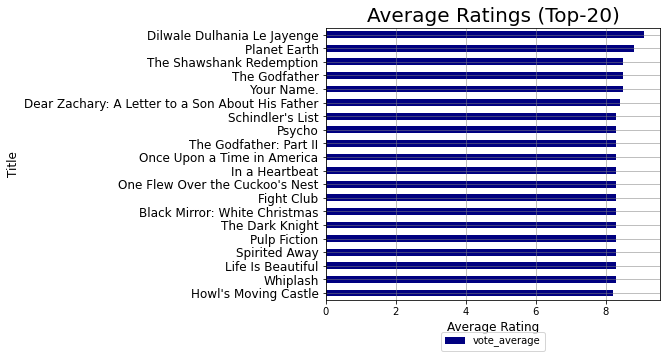

In [18]:
count_mean = movies.vote_count.mean()
d = movies.sort_values(by="vote_average", ascending=False).query(f"vote_count > {count_mean}")[0:20]
plt.figure()
ax = d.plot.barh(x="title",y="vote_average", figsize=(6, 5), colormap='jet', rot=0)
ax.tick_params(axis='y', labelsize=12, rotation=0); ax.tick_params(axis='x', labelsize=10, rotation=0)
ax.set_xlabel('Average Rating', fontsize=12); ax.set_ylabel('Title', fontsize=12)
ax.set_title('Average Ratings (Top-20)', fontsize=20)
ax.grid(which = "major", color="gray", linewidth=0.5)
ax.invert_yaxis()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
plt.show()

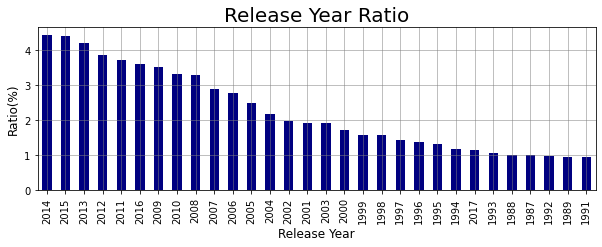

In [19]:
plt.figure()
d = movies.release_date.value_counts(normalize=True)[0:30] * 100
ax = d.plot(kind='bar', figsize=(10, 3), colormap='jet', rot=0)
ax.tick_params(axis='x', labelsize=10, rotation=90);ax.tick_params(axis='y', labelsize=10, rotation=0)
ax.set_ylabel('Ratio(%)', fontsize=12); ax.set_xlabel('Release Year', fontsize=12)
ax.set_title('Release Year Ratio', fontsize=20)
ax.grid(which = "major", color="gray", linewidth=0.5)
plt.show()

In [20]:
g = defaultdict(list)
c = defaultdict(list)
k = defaultdict(list)
for i in tqdm(range(0, len(movies))):
    row = movies.iloc[i, :]
    if row.genres == None or row.cast == None or row.keywords == None: continue
    title = row.title
    for j in row.genres:
        g[j].append(title)
    for j in row.cast:
        c[j].append(title)
    for j in row.keywords:
        k[j].append(title)
g = dict( {i:list(set(j)) for i, j in g.items()} )
c = dict( {i:list(set(j)) for i, j in c.items()} )
k = dict( {i:list(set(j)) for i, j in k.items()} )

100%|██████████| 46628/46628 [00:11<00:00, 4079.34it/s]


<Figure size 432x288 with 0 Axes>

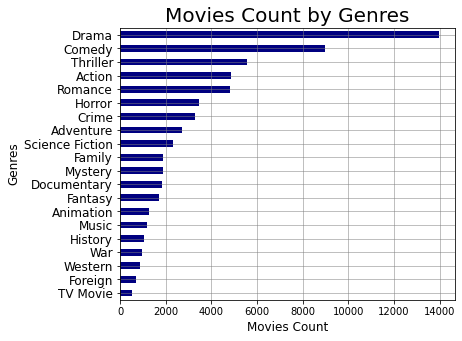

In [21]:
plt.figure()
d = pd.DataFrame.from_dict( { i:len(j) for i,j in g.items() }, orient='index' ).sort_values(by=0, ascending=False)
ax = d.plot.barh(figsize=(6, 5), colormap='jet', rot=0, legend=None)
ax.tick_params(axis='y', labelsize=12, rotation=0); ax.tick_params(axis='x', labelsize=10, rotation=0)
ax.set_xlabel('Movies Count', fontsize=12); ax.set_ylabel('Genres', fontsize=12)
ax.set_title('Movies Count by Genres', fontsize=20)
ax.grid(which = "major", color="gray", linewidth=0.5)
ax.invert_yaxis()
plt.show()

<Figure size 432x288 with 0 Axes>

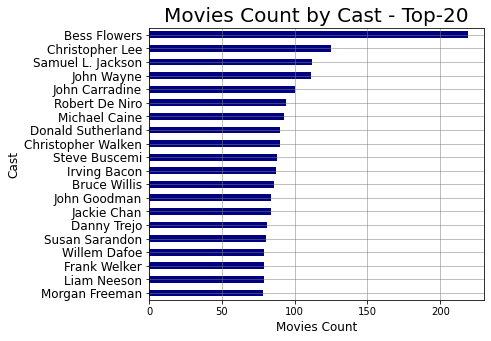

In [22]:
plt.figure()
d = pd.DataFrame.from_dict( { i:len(j) for i,j in c.items() }, orient='index' ).sort_values(by=0, ascending=False)[0:20]
ax = d.plot.barh(figsize=(6, 5), colormap='jet', rot=0, legend=None)
ax.tick_params(axis='y', labelsize=12, rotation=0); ax.tick_params(axis='x', labelsize=10, rotation=0)
ax.set_xlabel('Movies Count', fontsize=12); ax.set_ylabel('Cast', fontsize=12)
ax.set_title('Movies Count by Cast - Top-20', fontsize=20)
ax.grid(which = "major", color="gray", linewidth=0.5)
ax.invert_yaxis()
plt.show()

<Figure size 432x288 with 0 Axes>

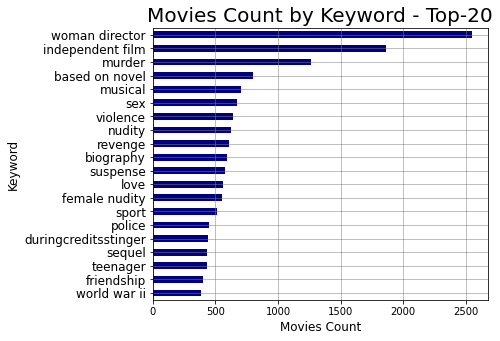

In [23]:
plt.figure()
d = pd.DataFrame.from_dict( { i:len(j) for i,j in k.items() }, orient='index' ).sort_values(by=0, ascending=False)[0:20]
ax = d.plot.barh(figsize=(6, 5), colormap='jet', rot=0, legend=None)
ax.tick_params(axis='y', labelsize=12, rotation=0); ax.tick_params(axis='x', labelsize=10, rotation=0)
ax.set_xlabel('Movies Count', fontsize=12); ax.set_ylabel('Keyword', fontsize=12)
ax.set_title('Movies Count by Keyword - Top-20', fontsize=20)
ax.grid(which = "major", color="gray", linewidth=0.5)
ax.invert_yaxis()
plt.show()

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

# Recommendation

## Class Definitions

### Data Class

In [24]:
# https://github.com/oreilly-japan/RecommenderSystems/blob/main/chapter5/util/metric_calculator.py
@dataclasses.dataclass(frozen=True)
class Dataset:
    train: pd.DataFrame
    # test-set for ranking evaluation
    test_user2items: Dict[int, List[int]]
    # item information table
    item_content: pd.DataFrame = dataclasses.field(default=0, init=False)


@dataclasses.dataclass(frozen=True)
class Metrics:
    precision_at_k: float
    recall_at_k: float
    # transform results for output
    def __repr__(self):
        return f"Precision@K={self.precision_at_k:.3f}, Recall@K={self.recall_at_k:.3f}"

### Data Loader

In [25]:
# https://github.com/oreilly-japan/RecommenderSystems/blob/main/chapter5/util/data_loader.py
class DataLoader:
    def __init__(self, ratings: pd.DataFrame, movies: pd.DataFrame, num_test_items: int = 5):
        self.num_test_items = num_test_items
        self.ratings = movie_ratings
        self.movies = movies

    def load(self) -> Dataset:
        ratings_train, ratings_test = self._split_data(self.ratings)
        """ 
        transform ratings_test for evaluation
        extract records with over4 rating
        transform DataFrame to Dict ( user : [high-rating movies id] )
        """
        movielens_test_user2items = (
            ratings_test[ratings_test.rating >= 4].groupby("userId").agg({"movieId": list})["movieId"].to_dict()
        )
        return Dataset(ratings_train, movielens_test_user2items)

    def _split_data(self, ratings: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):       
        # get rating-order by each users 
        ratings["rating_order"] = ratings.groupby("userId")["timestamp"].rank(ascending=False, method="first")
        # near-{num_test_items} items for test, the others for train
        ratings_train = ratings[ratings["rating_order"] > self.num_test_items]
        ratings_test = ratings[ratings["rating_order"] <= self.num_test_items]
        return ratings_train, ratings_test

In [26]:
data = DataLoader(movie_ratings, movies).load()

### Evaluation Functions

In [27]:
# https://github.com/oreilly-japan/RecommenderSystems/blob/main/chapter5/util/metric_calculator.py
class MetricCalculator:
    def calc(self, true_user2items: Dict[int, List[int]], pred_user2items: Dict[int, List[int]],k: int,) -> Metrics:
        precision_at_k = self._calc_precision_at_k(true_user2items, pred_user2items, k)
        recall_at_k = self._calc_recall_at_k(true_user2items, pred_user2items, k)
        return Metrics(precision_at_k, recall_at_k)

    def _precision_at_k(self, true_items: List[int], pred_items: List[int], k: int) -> float:
        if k == 0:
            return 0.0
        p_at_k = (len(set(true_items) & set(pred_items[:k]))) / k
        return p_at_k

    def _recall_at_k(self, true_items: List[int], pred_items: List[int], k: int) -> float:
        if len(true_items) == 0 or k == 0:
            return 0.0
        r_at_k = (len(set(true_items) & set(pred_items[:k]))) / len(true_items)
        return r_at_k

    def _calc_recall_at_k(self, true_user2items: Dict[int, List[int]], pred_user2items: Dict[int, List[int]], k: int) -> float:
        scores = []
        for user_id in true_user2items.keys():
            if user_id in pred_user2items:
                r_at_k = self._recall_at_k(true_user2items[user_id], pred_user2items[user_id], k)
                scores.append(r_at_k)
            else:
                continue
        return np.mean(scores)

    def _calc_precision_at_k(self, true_user2items: Dict[int, List[int]], pred_user2items: Dict[int, List[int]], k: int) -> float:
        scores = []
        for user_id in true_user2items.keys():
            if user_id in pred_user2items:
                p_at_k = self._precision_at_k(true_user2items[user_id], pred_user2items[user_id], k)
                scores.append(p_at_k)
            else:
                continue
        return np.mean(scores)

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

## Popularity

In [28]:
# https://github.com/oreilly-japan/RecommenderSystems/blob/main/chapter5/src/popularity.py
def popularity_recommend(dataset: Dataset, minimum_num_rating: int = 200):   
    """
    Recommend 10 movies from those that have not yet been rated by each user, in the order of highest rating.
    """
    pred_user2items = defaultdict(list)
    user_watched_movies = dataset.train.groupby("userId").agg({"movieId": list})["movieId"].to_dict()
    movie_stats = dataset.train.groupby("movieId").agg({"rating": [np.size, np.mean]})
    atleast_flg = movie_stats["rating"]["size"] >= minimum_num_rating
    movies_sorted_by_rating = (
        movie_stats[atleast_flg].sort_values(by=("rating", "mean"), ascending=False).index.tolist()
    )

    for user_id in dataset.train.userId.unique():
        for movie_id in movies_sorted_by_rating:
            if movie_id not in user_watched_movies[user_id]:
                pred_user2items[user_id].append(movie_id)
            if len(pred_user2items[user_id]) == 10:
                break

    return pred_user2items

In [29]:
result = popularity_recommend(data, 200)
MetricCalculator().calc( data.test_user2items, result, k=10)

Precision@K=0.015, Recall@K=0.045

## Colloaborative Filter

In [30]:
# https://github.com/oreilly-japan/RecommenderSystems/blob/main/chapter5/src/umcf.py
def UMCF_recommend(dataset: Dataset):
    # transform for Surprise
    reader = Reader(rating_scale=(0.5, 5))
    data_train = SurpriseDataset.load_from_df( dataset.train[["userId", "movieId", "rating"]], reader ).build_full_trainset()
    """
    train model for prediction
    https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measure-configuration
    """
    sim_options = {"name": "pearson", "user_based": True}  # if false, item-based filtering
    """
    A basic collaborative filtering algorithm, taking into account the mean ratings of each user.
    https://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNWithMeans
    """
    knn = KNNWithMeans(k=30, min_k=1, sim_options=sim_options)
    knn.fit(data_train)

    # prepare  userID X movieId  pair with no ratings
    data_test = data_train.build_anti_testset(None)
    """
    return Prediction class 
    https://surprise.readthedocs.io/en/stable/predictions_module.html#surprise.prediction_algorithms.predictions.Prediction
    """
    predictions = knn.test(data_test)

    pred_user2items = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        pred_user2items[uid].append((iid, est))
    for uid, user_ratings in pred_user2items.items():
        """
        sort predictions for each users by ratings
        extract 10 movies for evaluation
        """
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        pred_user2items[uid] = [d[0] for d in user_ratings[:10]]

    return pred_user2items

In [31]:
result = UMCF_recommend(data)
MetricCalculator().calc( data.test_user2items, result, k=10)

Computing the pearson similarity matrix...
Done computing similarity matrix.


Precision@K=0.002, Recall@K=0.004

## Item2vec

In [32]:
# https://github.com/oreilly-japan/RecommenderSystems/blob/main/chapter5/src/item2vec.py
def Item2vec_recommend(dataset: Dataset, dims: int=100, n_epochs: int=10, window: int=10, use_skip_gram: int=1, min_count: int=5):
    item2vec_data = []
    train_high_rating = dataset.train[dataset.train.rating >= 4]
    for user_id, data in train_high_rating.groupby("userId"):
        # One sentence : each user's high-rated movies.
        item2vec_data.append(data.sort_values("timestamp")["movieId"].tolist())
    """
    train word2vec model
    https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
    """
    model = gensim.models.word2vec.Word2Vec(
        sentences=item2vec_data,
        vector_size=dims,
        window=window,
        sg=use_skip_gram,
        epochs=n_epochs,
        min_count=min_count,
    )

    pred_user2items = dict()
    for user_id, data in train_high_rating.groupby("userId"):
        input_data = []
        for item_id in data.sort_values("timestamp")["movieId"].tolist():
            if item_id in model.wv.key_to_index:
                input_data.append(item_id)
        if len(input_data) == 0:
            # return empty list if model input is None
            pred_user2items[user_id] = []
            continue
        """
        get_similar_movieId( mean( vectors for all input_data ) )
        https://tedboy.github.io/nlps/_modules/gensim/models/word2vec.html#Word2Vec.most_similar
        """
        recommended_items = model.wv.most_similar(input_data, topn=10)
        pred_user2items[user_id] = [d[0] for d in recommended_items]

    return pred_user2items

In [33]:
result = Item2vec_recommend(data)
MetricCalculator().calc( data.test_user2items, result, k=10)

Precision@K=0.007, Recall@K=0.020

## Matrix Factorization

In [34]:
# https://github.com/oreilly-japan/RecommenderSystems/blob/main/chapter5/src/mf.py
def MF_recommend(dataset: Dataset, factors: int=5, minimum_num_rating: int=100, use_biase: bool=False, lr_all: float=0.005, n_epochs: int=20):
    # Restrict to movies with at least minimum_num_rating ratings.
    filtered_train = dataset.train.groupby("movieId").filter( lambda x: len(x["movieId"]) >= minimum_num_rating)
    # transform for Surprise
    reader = Reader(rating_scale=(0.5, 5))
    data_train = SurpriseDataset.load_from_df( filtered_train[["userId", "movieId", "rating"]], reader).build_full_trainset()

    """
    The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize.
    In Surprise implementation, 'Matrix Factorization' is called just 'SVD'. 
    https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD
    """
    mf = SVD(n_factors=factors, n_epochs=n_epochs, lr_all=lr_all, biased=use_biase)
    mf.fit(data_train)

    # prepare  userID X movieId  pair with no ratings
    data_test = data_train.build_anti_testset(None)
    predictions = mf.test(data_test)
    
    pred_user2items = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        pred_user2items[uid].append((iid, est))
    for uid, user_ratings in pred_user2items.items():
        """
        sort predictions for each users by ratings
        extract 10 movies for evaluation
        """
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        pred_user2items[uid] = [d[0] for d in user_ratings[:10]]

    return pred_user2items

In [35]:
result = MF_recommend(data)
MetricCalculator().calc( data.test_user2items, result, k=10)

Precision@K=0.015, Recall@K=0.041

## Factorization Machines

In [36]:
# https://github.com/oreilly-japan/RecommenderSystems/blob/main/chapter5/src/fm.py
def FM_recommend(dataset: Dataset, factors: int=10, minimum_num_rating: int=100, use_side_information: bool=False, lr: float=0.01, n_epochs: int=20):
    # Restrict to movies with at least minimum_num_rating ratings.
    filtered_train = dataset.train.groupby("movieId").filter( lambda x: len(x["movieId"]) >= minimum_num_rating )
    # user-rated movies
    user_evaluated_movies = ( filtered_train.groupby("userId").agg({"movieId": list})["movieId"].to_dict() )
    # mean of user-rating
    user_average_rating = (filtered_train.groupby("userId").agg({"rating": np.mean})["rating"].to_dict())

    train_data_for_fm = []
    y = []
    for i, row in filtered_train.iterrows():
        x = {"userId": str(row["userId"]), "movieId": str(row["movieId"])}
        if use_side_information:
            x["user_rating_avg"] = user_average_rating[row["userId"]]
        train_data_for_fm.append(x)
        y.append(row["rating"])
    y = np.array(y)
    vectorizer = DictVectorizer()
    X = vectorizer.fit_transform(train_data_for_fm).toarray()

    """
    xlearn for Factorization Machines
    https://xlearn-doc.readthedocs.io/en/latest/python_api/index.html?highlight=fmmodel#scikit-learn-api-for-xlearn
    """
    fm = xl.FMModel(task="reg", metric="rmse", lr=lr, opt="sgd", k=factors, epoch=n_epochs)
    fm.fit(X, y, is_lock_free=False)

    unique_user_ids = sorted(filtered_train.userId.unique())
    unique_movie_ids = sorted(filtered_train.movieId.unique())
    user_id2index = dict(zip(unique_user_ids, range(len(unique_user_ids))))

    # create test data for evaluation
    test_data_for_fm = []
    for user_id in unique_user_ids:
        for movie_id in unique_movie_ids:
            x = {"userId": str(user_id), "movieId": str(movie_id)}
            if use_side_information:
                x["user_rating_avg"] = user_average_rating[user_id]
            test_data_for_fm.append(x)
    X_test = vectorizer.transform(test_data_for_fm).toarray()
    y_pred = fm.predict(X_test)
    pred_matrix = y_pred.reshape(len(unique_user_ids), len(unique_movie_ids))

    pred_user2items = defaultdict(list)
    for user_id in unique_user_ids:
        user_index = user_id2index[user_id]
        # get recommended movies list from prediction result
        movie_indexes = np.argsort(-pred_matrix[user_index, :])
        for movie_index in movie_indexes:
            movie_id = unique_movie_ids[movie_index]
            if movie_id not in user_evaluated_movies[user_id]:
                pred_user2items[user_id].append(movie_id)
            if len(pred_user2items[user_id]) == 10:
                break

    return pred_user2items

In [37]:
result = FM_recommend(data,use_side_information=True)
MetricCalculator().calc( data.test_user2items, result, k=10)

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x rmse) option.
[------------] xLearn uses 4 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (/tmp/tmp63cbge8s.bin) NOT found. Convert text file to binary file.
[------------] Number of Feature: 796
[------------] Time cost for reading problem: 0.03 (sec)
[ ACTION     ] Initialize model ...
[-----------

Precision@K=0.015, Recall@K=0.041

## Recbole

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

# References
- https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
- https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system
- https://www.kamishima.net/archive/recsysdoc.pdf
    - https://www.kamishima.net/archive/recsys.pdf
- https://github.com/oreilly-japan/RecommenderSystems
- Tensorflow Recommender 
    - https://www.kaggle.com/code/mfaaris/hybrid-and-tensorflow-recommender-system
- Notebooks
    - https://www.kaggle.com/code/duonghoanvu1/movie-recommendation
- Google ML(& Recommendation) Note
    - https://developers.google.com/machine-learning/guides/rules-of-ml
    - https://developers.google.com/machine-learning/recommendation

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>